# 定义计算图节点

In [4]:
import math


def to_constant(other):
    if not isinstance(other, AutoDiffOperation):
        return Const(other)
    else:
        return other


class AutoDiffOperation():

    def backward(self, var):
        pass

    def compute(self):
        pass

    def __add__(self, other):
        other = to_constant(other)
        return Sum(self, other)

    def __radd__(self, other):
        other = to_constant(other)
        return Sum(other, self)

    def __sub__(self, other):
        other = to_constant(other)
        return Sub(self, other)

    def __rsub__(self, other):
        other = to_constant(other)
        return Sub(other, self)

    def __mul__(self, other):
        other = to_constant(other)
        return Mul(self, other)

    def __rmul__(self, other):
        other = to_constant(other)
        return Mul(other, self)

    def __truediv__(self, other):
        other = to_constant(other)
        return Div(self, other)

    def __rtruediv__(self, other):
        other = to_constant(other)
        return Div(other, self)

    def __neg__(self):
        return Mul(Const(-1), self)


class Const(AutoDiffOperation):
    def __init__(self, value):
        self.value = value

    def backward(self, var):
        return 0

    def compute(self):
        return self.value


class Var(AutoDiffOperation):
    def __init__(self, name, value=None):
        self.name, self.value = name, value

    def backward(self, var):
        return 1 if self == var else 0

    def compute(self):
        return self.value


class Sum(AutoDiffOperation):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def backward(self, var):
        return self.x.backward(var) + self.y.backward(var)

    def compute(self):
        return self.x.compute() + self.y.compute()


class Sub(AutoDiffOperation):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def backward(self, var):
        return self.x.backward(var) - self.y.backward(var)

    def compute(self):
        return self.x.compute() - self.y.compute()


class Mul(AutoDiffOperation):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def backward(self, var):
        return self.x.backward(var) * self.y + self.x * self.y.backward(var)

    def compute(self):
        return self.x.compute() * self.y.compute()


class Div(AutoDiffOperation):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def backward(self, var):
        return (self.x.backward(var) * self.y - self.x * self.y.backward(var)) / (self.y * self.y)

    def compute(self):
        return self.x.compute() / self.y.compute()


class Exp(AutoDiffOperation):
    def __init__(self, x):
        self.x = x

    def backward(self, var):
        return Exp(self.x) * self.x.backward(var)

    def compute(self):
        return math.exp(self.x.compute())


class Log(AutoDiffOperation):
    def __init__(self, x):
        self.x = x

    def backward(self, var):
        return self.x.backward(var) / self.x

    def compute(self):
        return math.log(self.x.compute())

In [5]:
a = Var('a')
b = Var('b')

c = 2*a + b
a.value=2
b.value=3

print(c.backward(b).compute())


1


In [6]:
!pip install scikit-learn

# 神经网络自动微分

epoch: 0	loss: 1.218
epoch: 10	loss: 0.637
epoch: 20	loss: 0.512
epoch: 30	loss: 0.452
epoch: 40	loss: 0.415
epoch: 50	loss: 0.388
epoch: 60	loss: 0.367
epoch: 70	loss: 0.350
epoch: 80	loss: 0.335
epoch: 90	loss: 0.323
epoch: 100	loss: 0.311
epoch: 110	loss: 0.301
epoch: 120	loss: 0.292
epoch: 130	loss: 0.283
epoch: 140	loss: 0.275
epoch: 150	loss: 0.268
epoch: 160	loss: 0.261
epoch: 170	loss: 0.255
epoch: 180	loss: 0.248
epoch: 190	loss: 0.243
epoch: 200	loss: 0.237
epoch: 210	loss: 0.232
epoch: 220	loss: 0.227
epoch: 230	loss: 0.222
epoch: 240	loss: 0.218
epoch: 250	loss: 0.214
epoch: 260	loss: 0.210
epoch: 270	loss: 0.206
epoch: 280	loss: 0.202
epoch: 290	loss: 0.199
epoch: 300	loss: 0.195
epoch: 310	loss: 0.192
epoch: 320	loss: 0.189
epoch: 330	loss: 0.186
epoch: 340	loss: 0.183
epoch: 350	loss: 0.180
epoch: 360	loss: 0.178
epoch: 370	loss: 0.175
epoch: 380	loss: 0.173
epoch: 390	loss: 0.170
epoch: 400	loss: 0.168
epoch: 410	loss: 0.166
epoch: 420	loss: 0.164
epoch: 430	loss: 0.162

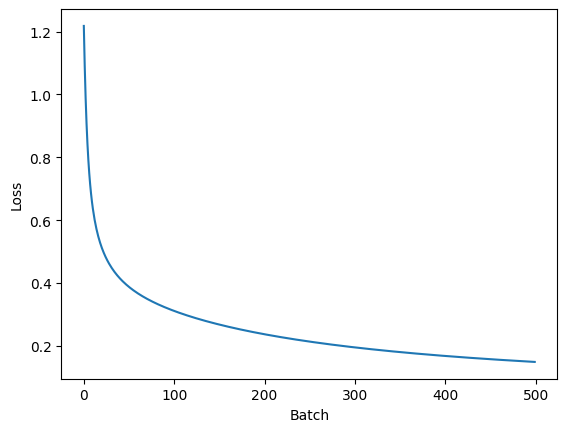

In [7]:
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


iris = datasets.load_iris()
X = StandardScaler().fit_transform(iris.data)
y = np.zeros((iris.target.shape[0], 3))
for i, t in enumerate(iris.target):
    y[i][t] = 1.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



class AutoDiffNeuralNetwork:
    def __init__(self, input_size, output_size, learning_rate):
        self.learning_rate = learning_rate

        self.x_vars = [Var(f'x_{i}') for i in range(input_size)]

        self.param_vars, self.z_vars, self.y_vars = [], [], []
        for i in range(output_size):
            b = Var(f'b_{i}', value=0)
            ws = [Var(f'w_{i}_{j}', value=v) for j,v in enumerate(np.random.normal(scale=0.1, size=input_size))]

            z_i = b + sum(w * x for w, x in zip(ws, self.x_vars))

            y = Var(f'y_{i}')

            self.param_vars.extend(ws)
            self.param_vars.append(b)
            self.z_vars.append(z_i)
            self.y_vars.append(y)

        softmax_base = sum(Exp(z) for z in self.z_vars)
        self._outputs = [Exp(z) / softmax_base for z in self.z_vars]

        self._loss = -sum(l * Log(o) for l, o in zip(self.y_vars, self._outputs))
        self._grads = [self._loss.backward(p) for p in self.param_vars]

    def backprop(self, batch_x, batch_y):

        grads = [0.0] * len(self._grads)
        loss = 0.0

        for x, y in zip(batch_x, batch_y):

            for input_, value in zip(self.x_vars, x):
                input_.value = value
            for label_, value in zip(self.y_vars, y):
                label_.value = value

            loss += self._loss.compute()
            for i, g in enumerate(self._grads):
                grads[i] += g.compute()

        for p, g in zip(self.param_vars, grads):
            p.value = p.value - self.learning_rate * g

        return loss / len(batch_x)

    def train(self, X, y, epochs):
        errors = []
        batch_count = 0
        for epoch in range(epochs):
            loss = self.backprop(X, y)
            errors.append(loss)

            if epoch % 10 == 0:
                print(f'epoch: {epoch}\tloss: {loss:.3f}')

        return errors

    def predict(self, batch_x):
        preds = []
        for x in batch_x:
            for input_, value in zip(self.x_vars, x):
                input_.value = value

            preds.append([o.compute() for o in self._outputs])

        return preds

model = AutoDiffNeuralNetwork(X_train.shape[1], y_train.shape[1], 0.001)
history = model.train(X_train, y_train, 500)

plt.plot(history)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [8]:
pred = model.predict(X_test)
pred = [np.argmax(p) for p in pred]
for i, p in enumerate(pred):
    print(np.argmax(y_test[i]), p)

1 1
2 2
2 2
1 1
0 0
0 0
0 0
2 2
0 0
1 1
2 2
2 2
0 0
1 2
0 0
0 0
1 1
1 1
2 1
0 0
2 1
1 1
1 1
2 2
0 0
0 0
1 1
0 0
0 0
0 0


In [4]:
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


iris = datasets.load_iris()
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

# pytorch的自动微分

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

iris = load_iris()
X = iris.data
y = iris.target
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for i, (inputs, labels) in enumerate(train_loader):
#     print(i, labels)

# Define the model
class IrisClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(IrisClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

model = IrisClassifier(input_size=4, num_classes=3)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Batch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


Batch [10/100], Loss: 0.8737
Batch [20/100], Loss: 0.4375
Batch [30/100], Loss: 0.6959
Batch [40/100], Loss: 0.2776
Batch [50/100], Loss: 0.5292
Batch [60/100], Loss: 0.5244
Batch [70/100], Loss: 0.2682
Batch [80/100], Loss: 0.3753
Batch [90/100], Loss: 0.4253
Batch [100/100], Loss: 0.1872
